In [23]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import math
import time
import os
import random

# Make the VF Solution and use it as input to network

import sys
sys.path.insert(0,'..')
import VF.vectorfit

In [24]:
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:5


# 1. Load the data and get measurements

In [25]:
ROOT_PATH = "/scratch/cluster/bodeng/UTAFSDataNew/new_data"
CHIP_NUM = 20

In [26]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [27]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [28]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (3, 2, 1500)
GT S-parameters shape:  (3, 2, 1500)
Y S-parameters shape:  (3, 2, 62)


In [29]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (1500,)
Y frequencies shape:  (62,)


In [30]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  100000000.0
Mean frequency spacing:  100000000.0
STD frequency spacing:  4.416102007326934e-06
Mode frequency spacing:  100000000.0
Number of samples with non-equal spacing:  126


In [31]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [32]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  1500
N_SPARAMS:  3


In [33]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 6, 1500])


In [34]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 3, 1500])


## Plot some stuff

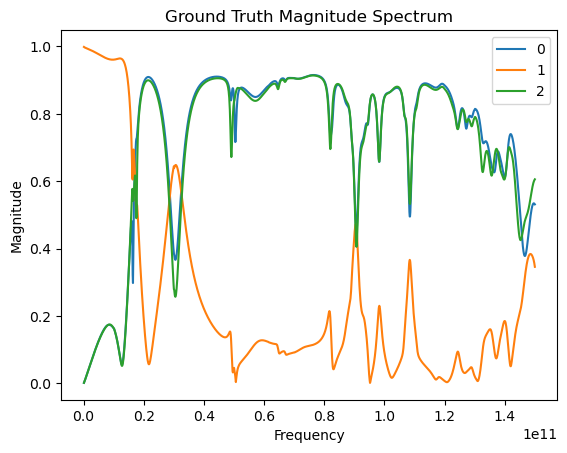

In [35]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

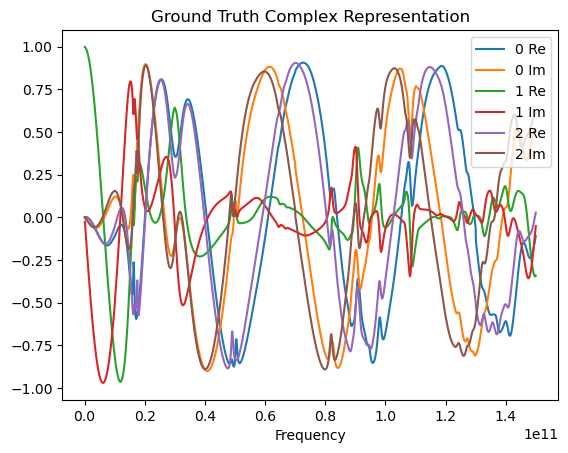

In [36]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [37]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = 62

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)
old_kept = kept_inds.copy()

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

# remove every other point, starting at the back, don't remove first point
remove = False
for i in range(len(kept_inds) - 1, 0, -1):
    if remove:
        kept_inds = np.delete(kept_inds, [i])
        remove = False
    else:
        remove = True

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)
print(kept_inds)
print(old_kept)

Number of Ground Truth Frequency Points:  1500
Number of Measurements:  62
Undersampling Ratio:  0.04133333333333333
[   0   24   73  122  172  221  270  319  368  417  466  516  565  614
  663  712  761  810  860  909  958 1007 1056 1105 1154 1204 1253 1302
 1351 1400 1449 1499]
[   0   24   49   73   98  122  147  172  196  221  245  270  294  319
  344  368  393  417  442  466  491  516  540  565  589  614  638  663
  688  712  737  761  786  810  835  860  884  909  933  958  982 1007
 1032 1056 1081 1105 1130 1154 1179 1204 1228 1253 1277 1302 1326 1351
 1376 1400 1425 1449 1474 1499]


In [38]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 6, 32])
y_freqs shape:  (32,)


# 2. Network Setup

## Define network parameters

In [39]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False
USE_SGLD = False

In [40]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  6
NUM_LAYERS:  7
BASE NGF:  16
NGF:  [16, 16, 16, 16, 16, 16, 16]
BS:  1
NC:  6
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [41]:
from models import RES_UNET

net = RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0.0
               )
net = net.to(device)

In [42]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 6, 1500])


In [43]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  26002


# 3. Run

## Define training parameters, losses, and track stats

In [44]:
#grab the correct file we want for VF
NUM_ACTIVE = M - len(kept_inds)

LR = 2e-4
FIRST_ITER = 20000
NUM_ITER = 2000
CURR_ITER = FIRST_ITER
TOTAL_ITERS = FIRST_ITER + NUM_ITER * NUM_ACTIVE
NUM_BURN_ITER = NUM_ITER * 0 # 0.2
SAMPLE_EVERY = 40

ACTIVE_ITER_RATIO = 0.1
SAMPLE_LAST_N = NUM_ITER * ACTIVE_ITER_RATIO

# TODO: maybe come back to this?
# TOTAL_ITER = NUM_ITER + 0.1 * NUM_ACTIVE * NUM_ITER

REG_HYPERPARAM = 1.0
NOISY_INPUT = True
USE_SGLD = False

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

optim = torch.optim.Adam(net.parameters(), lr=LR)

def get_lr(optim):
    for g in optim.param_groups:
        return g['lr']
    
def set_lr(optim, lr):
    for g in optim.param_groups:
        g['lr'] = lr
        
START_NOISE_LEVEL = CUR_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / TOTAL_ITERS) 

train_losses = []
train_errors = []
if REG_HYPERPARAM > 0:
    train_regs = []

test_mses = []
test_maes = []

is_initial_fit = True
tic = time.time()
net.train()

# (NUM_ACTIVE + 1) * NUM_OUTPUTS * S_PARAMS * FREQS
sgld_outputs_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_means_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_stds_by_sample = []

print("NUM ACTIVE: ", NUM_ACTIVE)

for num_actively_sampled in range(NUM_ACTIVE + 1):

    cur_sgld_outputs = torch.Tensor().to(device)   

    if not is_initial_fit:

        LENGTH_GT = len(gt_freqs)
        cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
        fname = os.path.join(ROOT_PATH, "case"+cn)

        children = os.listdir(fname)
        children = [f for f in children if cn + ".s" in f]

        final_path = os.path.join(fname, children[0])

        fitter = VF.vectorfit.VectorFitter(final_path)
        fit1 = fitter.vector_fit("VF Result", y_freqs) 
        vf_output = fit1.fitted_network.s

        vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
        vf_data = utils.matrix_to_sparams(vf_data)
        vf_data = torch.tensor(vf_data).view(1, -1, LENGTH_GT)
        vf_data = vf_data.to(device)

        
        # Find the maximum standard deviation point, and use it to update kept_inds
        print(sgld_outputs_by_sample)
        max_disagree_idx = find_max_variance(sgld_outputs_by_sample[-1][-1], vf_data, pickRandom=False)
        kept_inds = np.sort(np.append(kept_inds, max_disagree_idx))
        print(kept_inds)

        # Recreate the y data with the new kept_inds
        y = torch.clone(x)[:, :, kept_inds]
        y_freqs = gt_freqs[kept_inds]


    # Update the criterion to reflect the new point we have sampled
    criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
    criterion = criterion.to(device)


    for i in range(int(CURR_ITER)):
        optim.zero_grad()
        
        if NOISY_INPUT:
            out = net.forward_with_z(CUR_NOISE_LEVEL)
            CUR_NOISE_LEVEL *= NOISE_DECAY_FACTOR
        else:
            out = net.forward_with_z()
        
        train_error = criterion(out, y) 
        if REG_HYPERPARAM > 0:
            train_reg = REG_HYPERPARAM * regularizer(out)
            train_loss = train_error + train_reg
        else:
            train_loss = train_error
        
        train_loss.backward()
        optim.step()

        with torch.no_grad():
            # First 20% of training will be burn-in iterations
            if (not is_initial_fit or i > NUM_BURN_ITER) and USE_SGLD:
                # Perform SGLD by adding Gaussian noise to parameters after gradient descent
                for param in net.parameters():
                    # param.add_(torch.normal(0, get_lr(optim), size=param.size()).to(device))
                    param.add_(torch.randn_like(param) * get_lr(optim) * 2)
            
            # Log the standard metrics across different numbers of samples given
            train_losses.append(train_loss.item())
            train_errors.append(train_error.item())
            if REG_HYPERPARAM > 0:
                train_regs.append(train_reg.item())
            
            test_mse = nn.MSELoss()(out, x)
            test_mses.append(test_mse.item())
            
            test_mae = nn.L1Loss()(out, x)
            test_maes.append(test_mae.item())

            if (i+1)%1000 == 0 or i == 0:
                toc = time.time()
                print("ITER ", str(i))
                print("TIME: ", str(toc - tic))
                if NOISY_INPUT:
                    print("NOISE LEVEL: ", CUR_NOISE_LEVEL)
                print()

            # Get SGLD outputs for finding mean/std
            if (NUM_ITER - i <= SAMPLE_LAST_N) and i % SAMPLE_EVERY == 0:
                cur_sgld_outputs = torch.cat([cur_sgld_outputs, out])

    sgld_outputs_by_sample.append(cur_sgld_outputs)
    sgld_means_by_sample.append(torch.mean(cur_sgld_outputs, dim=0))
    sgld_stds_by_sample.append(torch.std(cur_sgld_outputs, dim=0))

    if is_initial_fit :
    #     NUM_ITER *= ACTIVE_ITER_RATIO
        CURR_ITER = NUM_ITER
        is_initial_fit = False


    def find_max_variance(outputs, vf_outputs, pickRandom=False):
        # Outputs of shape [NUM_OUTPUTS, 20, 1000]

        # Call np.var with dim = 0 to get shape [20, 1000]
        print(vf_outputs.shape)
        print(outputs.shape)
        sqr_differences = torch.square(torch.subtract(vf_outputs[0], outputs))

        # Sum to go to [1000]
        sqr_differences = torch.mean(sqr_differences, dim=0)

        if pickRandom:
            while True:
                rand_idx = random.randint(0, len(sqr_differences) - 1)
                if rand_idx not in kept_inds:
                    print("picked: ", rand_idx)
                    return rand_idx

        _, idxs = torch.topk(sqr_differences, len(sqr_differences))

        for idx in idxs:
            if idx.item() not in kept_inds:
                return idx.item()
        return -1
    
    print("NUM_SAMPLES ", str(num_actively_sampled))
    print("TIME: ", str(toc - tic))


NUM ACTIVE:  30
ITER  0
TIME:  4.228591442108154
NOISE LEVEL:  0.9999136567868026

ITER  999
TIME:  39.14292812347412
NOISE LEVEL:  0.9172759353897951

ITER  1999
TIME:  73.80889701843262
NOISE LEVEL:  0.841395141645221

ITER  2999
TIME:  108.92318654060364
NOISE LEVEL:  0.7717915155850473

ITER  3999
TIME:  144.13758778572083
NOISE LEVEL:  0.7079457843841813

ITER  4999
TIME:  177.58829045295715
NOISE LEVEL:  0.6493816315762609

ITER  5999
TIME:  212.09514713287354
NOISE LEVEL:  0.5956621435290617

ITER  6999
TIME:  244.45059204101562
NOISE LEVEL:  0.5463865498819098

ITER  7999
TIME:  279.4545085430145
NOISE LEVEL:  0.5011872336273314

ITER  8999
TIME:  314.39131927490234
NOISE LEVEL:  0.4597269885309338

ITER  9999
TIME:  350.13244915008545
NOISE LEVEL:  0.4216965034286451

ITER  10999
TIME:  385.2800862789154
NOISE LEVEL:  0.386812054633115

ITER  11999
TIME:  420.86518359184265
NOISE LEVEL:  0.3548133892336386

ITER  12999
TIME:  456.0523889064789
NOISE LEVEL:  0.32546178349810806

/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.04332091100513935 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 4 (err 0.3394033569817908 vs 0.5918172492902904)
Performing fit with 5 poles.
  Fitting took 0.09056196548044682 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better than 5 (err 0.11903266667114218 vs 0.3394033569817908)
Performing fit with 6 poles.
  Fitting took 0.08852728456258774 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 7 poles better than 6 (err 0.10803646476869022 vs 0.11903266667114218)
Performing fit with 7 poles.
  Fitting took 0.0628455001860857 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 8 poles better than 7 (err 0.0931911436909917 vs 0.10803646476869022)
Performing fit with 8 poles.


/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. 
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.16036573983728886 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 9 poles better than 8 (err 0.026378670957281504 vs 0.0931911436909917)
Performing fit with 9 poles.
  Fitting took 0.06501605734229088 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 10 poles better than 9 (err 0.008433849595145666 vs 0.026378670957281504)
Performing fit with 10 poles.
  Fitting took 0.046109410002827644 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 11 poles better than 10 (err 0.007114388002920005 vs 0.008433849595145666)
Performing fit with 11 poles.
  Fitting took 0.05797051638364792 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 12 poles better than 11 (err 0.004631794542534889 vs 0.007114388002920005)
Performing fit with 12 poles.
  Fitting took 0.0765460878610611 seconds.
  Filling sampled 

/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: RuntimeWarning: Replacing d_res solution as it was too small. This is not a good sign and probably means that more starting poles are required
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.9721804708242416 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 7 was not subtantially better than 6 (err 0.14355409969121127 vs 0.10796647400974163)
Performing fit with 7 poles.
  Fitting took 0.5910147204995155 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 8 poles better than 6 (err 0.09684065008478097 vs 0.10796647400974163)
Performing fit with 8 poles.
  Fitting took 0.9144647996872663 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 9 poles better than 8 (err 0.02952807503065925 vs 0.09684065008478097)
Performing fit with 9 poles.
  Fitting took 0.7646032888442278 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 10 poles better than 9 (err 0.02619914303069343 vs 0.02952807503065925)
Performing fit with 10 poles.
  Fitting took 0.29003481194376945 seconds.
  Filling sampled n

/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 342994720955.68567). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.10887009464204311 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 was not subtantially better than 2 (err 1.6595470354178026 vs 1.2329782629676291)
Performing fit with 3 poles.
  Fitting took 0.05522482097148895 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 2 (err 0.5508881407651874 vs 1.2329782629676291)
Performing fit with 4 poles.
  Fitting took 0.060263821855187416 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 4 (err 0.3736354620661366 vs 0.5508881407651874)
Performing fit with 5 poles.
  Fitting took 0.6032570209354162 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better than 5 (err 0.107533036538207 vs 0.3736354620661366)
Performing fit with 6 poles.
  Fitting took 0.36361370235681534 seconds.
  Filling sampled network.

/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 19581063964.740124). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fit with 4 poles better than 2 (err 0.6313822578240328 vs 1.311724606239527)
Performing fit with 4 poles.
  Fitting took 0.026211926713585854 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 4 (err 0.3952719137817462 vs 0.6313822578240328)
Performing fit with 5 poles.
  Fitting took 0.12232990004122257 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better than 5 (err 0.1087430243704126 vs 0.3952719137817462)
Performing fit with 6 poles.
  Fitting took 0.17392718605697155 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 7 was not subtantially better than 6 (err 0.13917871122374842 vs 0.1087430243704126)
Performing fit with 7 poles.
  Fitting took 0.0466116089373827 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 8 was not subtantially better than 6 (err 0.11739251054535

/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 68031024598010.82). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.02115936018526554 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 4 (err 0.39331656973175255 vs 0.527960346693467)
Performing fit with 5 poles.
  Fitting took 0.15404805354773998 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better than 5 (err 0.10694944264355846 vs 0.39331656973175255)
Performing fit with 6 poles.
  Fitting took 0.09021992050111294 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 7 was not subtantially better than 6 (err 0.1395417443263344 vs 0.10694944264355846)
Performing fit with 7 poles.
  Fitting took 0.2098833080381155 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 8 was not subtantially better than 6 (err 0.11117886303347728 vs 0.10694944264355846)
Performing fit with 8 poles.
  Fitting took 0.08942729607224464 seconds.
  Fill

/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 11861175450.512026). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.1350207906216383 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 was not subtantially better than 2 (err 1.630114987653548 vs 1.3717236717716828)
Performing fit with 3 poles.
  Fitting took 0.0443942416459322 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 2 (err 0.5272828061163131 vs 1.3717236717716828)
Performing fit with 4 poles.
  Fitting took 0.054339900612831116 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 4 (err 0.39690424372032884 vs 0.5272828061163131)
Performing fit with 5 poles.
  Fitting took 0.957194359973073 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better than 5 (err 0.10441014542471183 vs 0.39690424372032884)
Performing fit with 6 poles.
  Fitting took 0.9985279757529497 seconds.
  Filling sampled network.


/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 10630018772.535557). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.0323831457644701 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 4 (err 0.40464733122387453 vs 0.5287663159175964)
Performing fit with 5 poles.
  Fitting took 0.1902899071574211 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better than 5 (err 0.10499949939564458 vs 0.40464733122387453)
Performing fit with 6 poles.
  Fitting took 0.5133794005960226 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 7 was not subtantially better than 6 (err 0.10879185828232853 vs 0.10499949939564458)
Performing fit with 7 poles.
  Fitting took 0.10864509828388691 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 8 was not subtantially better than 6 (err 0.10988907361320546 vs 0.10499949939564458)
Performing fit with 8 poles.
  Fitting took 0.06480672024190426 seconds.
  Fill

/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 12982160390.34005). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.1627450119704008 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 was not subtantially better than 2 (err 1.623113398567878 vs 1.2899847226163565)
Performing fit with 3 poles.
  Fitting took 0.08665578998625278 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 2 (err 0.529678239594894 vs 1.2899847226163565)
Performing fit with 4 poles.
  Fitting took 0.07502885907888412 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 4 (err 0.408206782675593 vs 0.529678239594894)
Performing fit with 5 poles.
  Fitting took 1.5267510116100311 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better than 5 (err 0.09160130208758241 vs 0.408206782675593)
Performing fit with 6 poles.
  Fitting took 1.2435271460562944 seconds.
  Filling sampled network.
  Fil

/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 484717577196.7509). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.15961450710892677 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 was not subtantially better than 2 (err 1.6185467180528341 vs 1.273682099732816)
Performing fit with 3 poles.
  Fitting took 0.09898377023637295 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 2 (err 0.5311404419113377 vs 1.273682099732816)
Performing fit with 4 poles.
  Fitting took 0.07967585697770119 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 4 (err 0.4111438374657809 vs 0.5311404419113377)
Performing fit with 5 poles.
  Fitting took 1.0203845873475075 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better than 5 (err 0.08532650885309678 vs 0.4111438374657809)
Performing fit with 6 poles.
  Fitting took 0.5495856944471598 seconds.
  Filling sampled network.
 

/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 79671292962.76624). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.11759545095264912 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 was not subtantially better than 2 (err 1.6233295007564577 vs 1.237800943302008)
Performing fit with 3 poles.
  Fitting took 0.04408368654549122 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 2 (err 0.5264467334761359 vs 1.237800943302008)
Performing fit with 4 poles.
  Fitting took 0.05392438359558582 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 4 (err 0.41457638078608977 vs 0.5264467334761359)
Performing fit with 5 poles.
  Fitting took 0.9591782446950674 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better than 5 (err 0.08342172049075836 vs 0.41457638078608977)
Performing fit with 6 poles.
  Fitting took 1.262736340984702 seconds.
  Filling sampled network.


/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 112750896639.50882). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.11796549521386623 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 was not subtantially better than 2 (err 1.6269684100421231 vs 1.2031781556592558)
Performing fit with 3 poles.
  Fitting took 0.0751135777682066 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 2 (err 0.5273165392204067 vs 1.2031781556592558)
Performing fit with 4 poles.
  Fitting took 0.07673691213130951 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 4 (err 0.4176636742032397 vs 0.5273165392204067)
Performing fit with 5 poles.
  Fitting took 0.2618515081703663 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better than 5 (err 0.08543046588989567 vs 0.4176636742032397)
Performing fit with 6 poles.
  Fitting took 0.6553147491067648 seconds.
  Filling sampled network.


/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 1840976307473.6594). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.04053829796612263 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 4 (err 0.36156583794360087 vs 0.5419875001106793)
Performing fit with 5 poles.
  Fitting took 0.9166437461972237 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better than 5 (err 0.10098902218743959 vs 0.36156583794360087)
Performing fit with 6 poles.
  Fitting took 0.7543966509401798 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 7 was not subtantially better than 6 (err 0.12546454170640398 vs 0.10098902218743959)
Performing fit with 7 poles.
  Fitting took 0.7059681788086891 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 8 poles better than 6 (err 0.09590586760414467 vs 0.10098902218743959)
Performing fit with 8 poles.
  Fitting took 0.1967494711279869 seconds.
  Filling sampled netw

In [45]:
# NUM_FORWARD_PASSES = 100
# sums_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# sums_squared_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# for i in range(NUM_FORWARD_PASSES):
#     sums_forward_pass_outputs += net.forward_with_z().cpu()
#     sums_squared_forward_pass_outputs += torch.square(net.forward_with_z()).cpu()

# mean_forward_pass_outputs = sums_forward_pass_outputs / NUM_FORWARD_PASSES
# std_forward_pass_outputs = torch.sqrt(((NUM_FORWARD_PASSES * sums_squared_forward_pass_outputs) - (sums_forward_pass_outputs * sums_forward_pass_outputs)) / (NUM_FORWARD_PASSES * (NUM_FORWARD_PASSES - 1)))

print(sgld_outputs_by_sample[0].shape)
print(sgld_means_by_sample[0].shape)
print(sgld_stds_by_sample[0].shape)

torch.Size([455, 6, 1500])
torch.Size([6, 1500])
torch.Size([6, 1500])


## Plot metrics and outputs

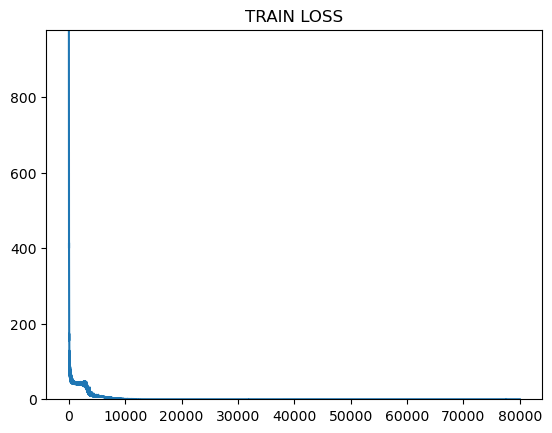

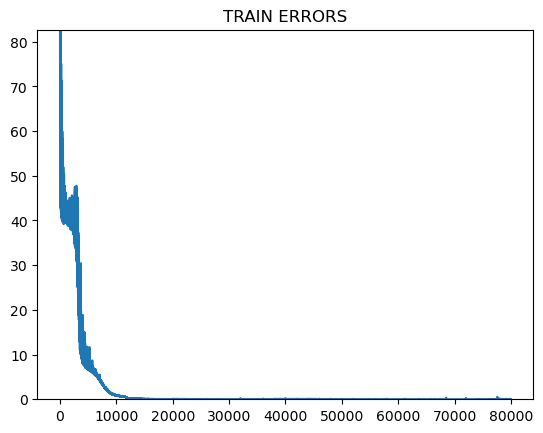

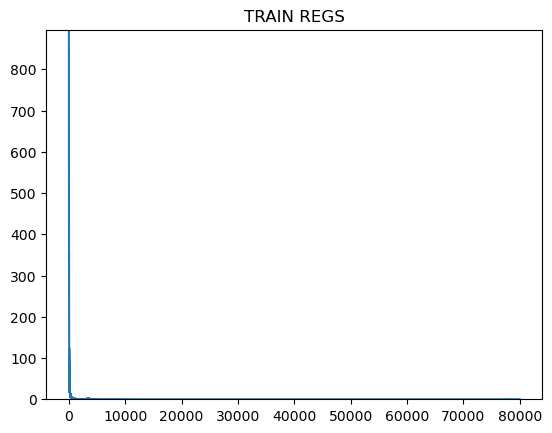

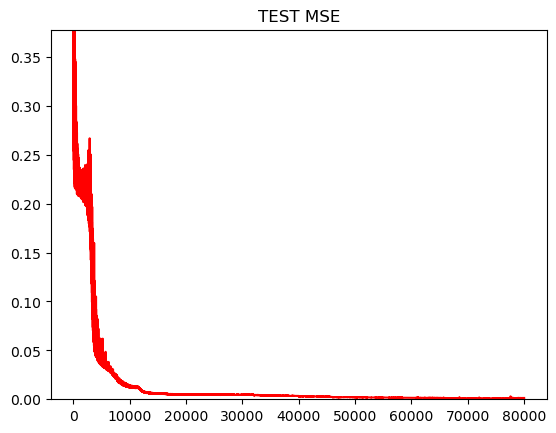

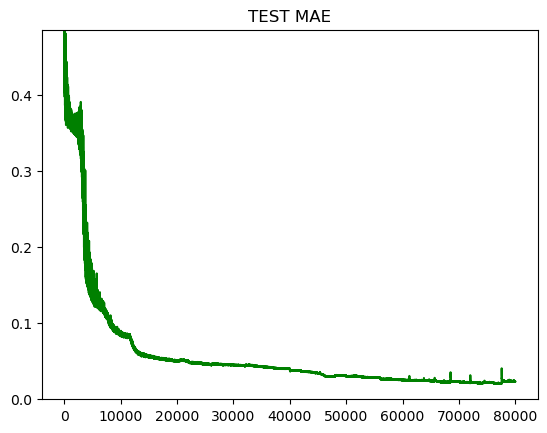

In [46]:
max_idx = 0

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [47]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  0.001328283571638167
Best Test MSE:  0.0009069960797205567
Best Test MSE Iteration:  76973


In [48]:
LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
print(y_freqs)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)
print(vf_data.shape)

/scratch/cluster/bodeng/UTAFSDataNew/new_data/case20/case20.s2p
[1.000e+08 2.500e+09 4.600e+09 7.400e+09 1.230e+10 1.470e+10 1.520e+10
 1.610e+10 1.660e+10 1.730e+10 1.930e+10 2.080e+10 2.220e+10 2.450e+10
 2.710e+10 3.160e+10 3.200e+10 3.690e+10 4.180e+10 4.670e+10 5.170e+10
 5.660e+10 6.150e+10 6.640e+10 7.130e+10 7.620e+10 8.110e+10 8.270e+10
 8.610e+10 8.960e+10 9.040e+10 9.050e+10 9.060e+10 9.100e+10 9.230e+10
 9.590e+10 9.800e+10 9.890e+10 1.008e+11 1.036e+11 1.057e+11 1.081e+11
 1.085e+11 1.086e+11 1.106e+11 1.155e+11 1.205e+11 1.228e+11 1.254e+11
 1.269e+11 1.274e+11 1.291e+11 1.303e+11 1.322e+11 1.352e+11 1.361e+11
 1.375e+11 1.401e+11 1.427e+11 1.450e+11 1.476e+11 1.500e+11]
Performing fit with 1 poles.
  Fitting took 0.031659023836255074 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.04777424782514572 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit w

In [49]:
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_data_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_data_mat.shape)
print(dip_data.dtype)
print(vf_data_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data_mat)
print("DIP PSNR:      ", psnr_ours)
print("VF PSNR:       ", psnr_vf)

print("Final DIP MSE: ", test_mses[-1])
print("VF MSE:        ", nn.MSELoss()(vf_data, x).item())
print("Mean DIP MSE: ", nn.MSELoss()(sgld_means_by_sample[-1][np.newaxis], x).item())

torch.Size([1500, 2, 2, 2])
torch.Size([1500, 2, 2, 2])
torch.Size([62, 2, 2, 2])
(1500, 2, 2, 2)
(1500, 2, 2, 2)
(3, 2, 1500)
(3, 2, 1500)
float32
float32
DIP PSNR:       34.787692326249584
VF PSNR:        25.555084732235258
Final DIP MSE:  0.001328283571638167
VF MSE:         0.01113144401460886
Mean DIP MSE:  0.001331606414169073


(1500,)
torch.Size([6, 1500])
torch.Size([1, 6, 1500])
torch.Size([1, 6, 62])
torch.Size([1, 6, 1500])
torch.Size([1, 6, 1500])


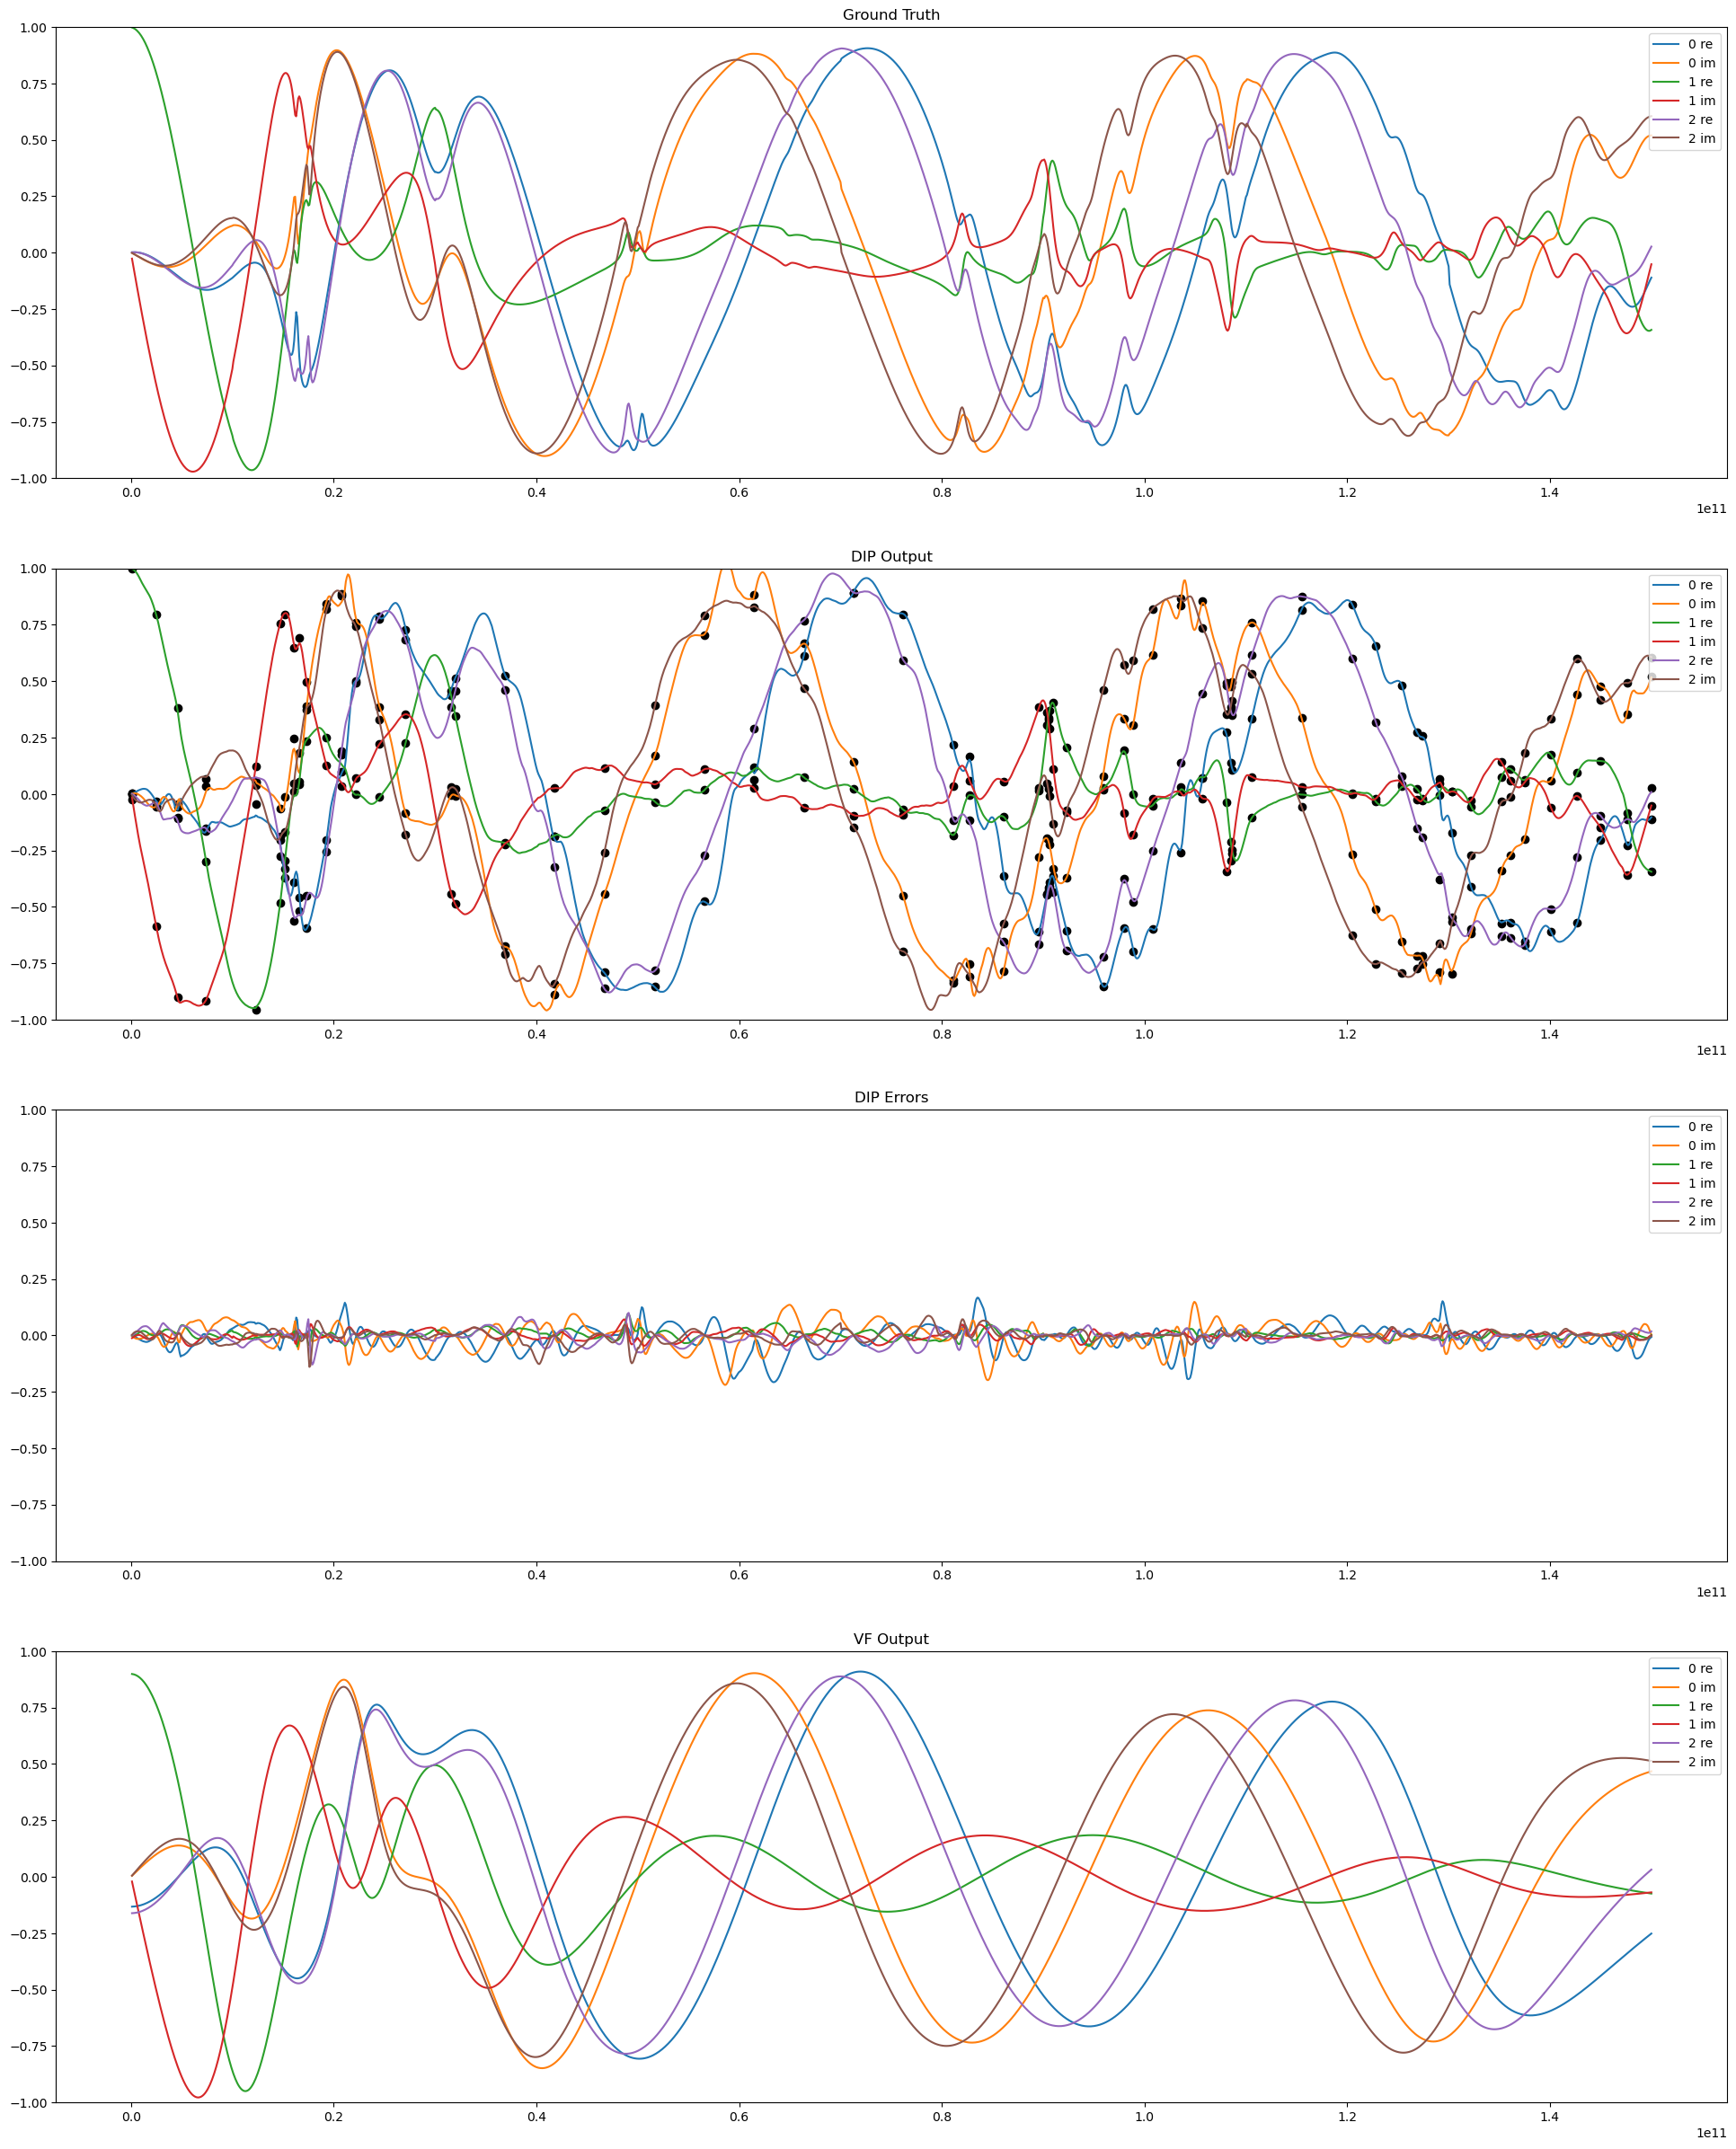

In [55]:
dip_errors = x.detach().cpu() - sgld_means_by_sample[-1].detach().cpu()
print(gt_freqs.shape)
print(sgld_means_by_sample[-1].shape)
print(dip_errors.shape)
print(y.shape)

print(out.shape)
print(vf_data.shape)

fig, axes = plt.subplots(4,1, figsize=(24, 30))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

# SHOW WITH MEAN AND STD DEVS
# for i in range(N_SPARAMS):

#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu(), label=str(i)+" re")
#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu(), label=str(i)+" im")
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i].detach().cpu(), sgld_means_by_sample[-1][2*i].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i].detach().cpu())
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu(), sgld_means_by_sample[-1][2*i+1].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu())

#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')


# axes[1].set_title("DIP Output")
# axes[1].set_ylim(-1,1)
# if N_SPARAMS <= 10:
#     axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")

    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')
axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[3].set_title("VF Output")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')

In [51]:
torch.set_printoptions(threshold=100000)
print(sgld_stds_by_sample[-1])

tensor([[5.5523e-04, 5.5985e-04, 5.7004e-04, 5.5005e-04, 4.9922e-04, 4.6317e-04,
         4.4397e-04, 4.5052e-04, 4.8427e-04, 5.6429e-04, 6.9514e-04, 7.9425e-04,
         8.5633e-04, 8.4472e-04, 7.6427e-04, 6.5671e-04, 5.3715e-04, 4.2997e-04,
         3.3687e-04, 2.7755e-04, 1.9834e-04, 1.4435e-04, 1.2520e-04, 1.3036e-04,
         1.4666e-04, 2.1034e-04, 2.4242e-04, 2.4700e-04, 2.2478e-04, 2.2776e-04,
         2.7235e-04, 5.3064e-04, 6.7452e-04, 7.4291e-04, 7.4445e-04, 5.9163e-04,
         3.6289e-04, 4.0357e-04, 3.5303e-04, 3.1941e-04, 3.3913e-04, 3.5607e-04,
         4.1791e-04, 4.7236e-04, 5.0380e-04, 7.3307e-04, 7.8478e-04, 6.8468e-04,
         4.6581e-04, 5.0731e-04, 4.5803e-04, 2.9714e-04, 1.5544e-04, 3.3453e-04,
         4.6008e-04, 4.8412e-04, 4.0753e-04, 3.2644e-04, 2.4576e-04, 1.8706e-04,
         2.1197e-04, 2.5963e-04, 2.4674e-04, 1.8190e-04, 2.0880e-04, 2.4538e-04,
         3.0457e-04, 3.1755e-04, 3.1020e-04, 2.8865e-04, 2.5407e-04, 2.1900e-04,
         1.8846e-04, 1.1174e

In [52]:
print(dip_errors[-1])

tensor([[-4.5170e-04, -1.1882e-03, -3.0497e-03, -5.4644e-03, -8.4688e-03,
         -1.1428e-02, -1.4339e-02, -1.7035e-02, -1.9506e-02, -2.1884e-02,
         -2.4163e-02, -2.5968e-02, -2.7294e-02, -2.8324e-02, -2.9054e-02,
         -2.8730e-02, -2.7350e-02, -2.5417e-02, -2.2930e-02, -1.9881e-02,
         -1.6268e-02, -1.2248e-02, -7.8168e-03, -4.3442e-03, -1.8814e-03,
          1.0733e-03,  3.8170e-03,  4.1209e-03,  1.8533e-03, -3.9807e-03,
         -1.3324e-02, -2.3408e-02, -3.4783e-02, -4.5998e-02, -5.7047e-02,
         -6.5424e-02, -7.1566e-02, -7.4673e-02, -7.4575e-02, -7.1176e-02,
         -6.4329e-02, -5.5869e-02, -4.5791e-02, -3.7699e-02, -3.2158e-02,
         -3.4135e-02, -5.1527e-02, -7.5938e-02, -9.3562e-02, -8.9695e-02,
         -8.8733e-02, -8.6864e-02, -8.4115e-02, -8.0800e-02, -7.6999e-02,
         -7.2460e-02, -6.7178e-02, -6.1360e-02, -5.5000e-02, -5.0494e-02,
         -4.7833e-02, -4.4796e-02, -4.1175e-02, -3.6621e-02, -3.2383e-02,
         -2.7125e-02, -2.0867e-02, -1.

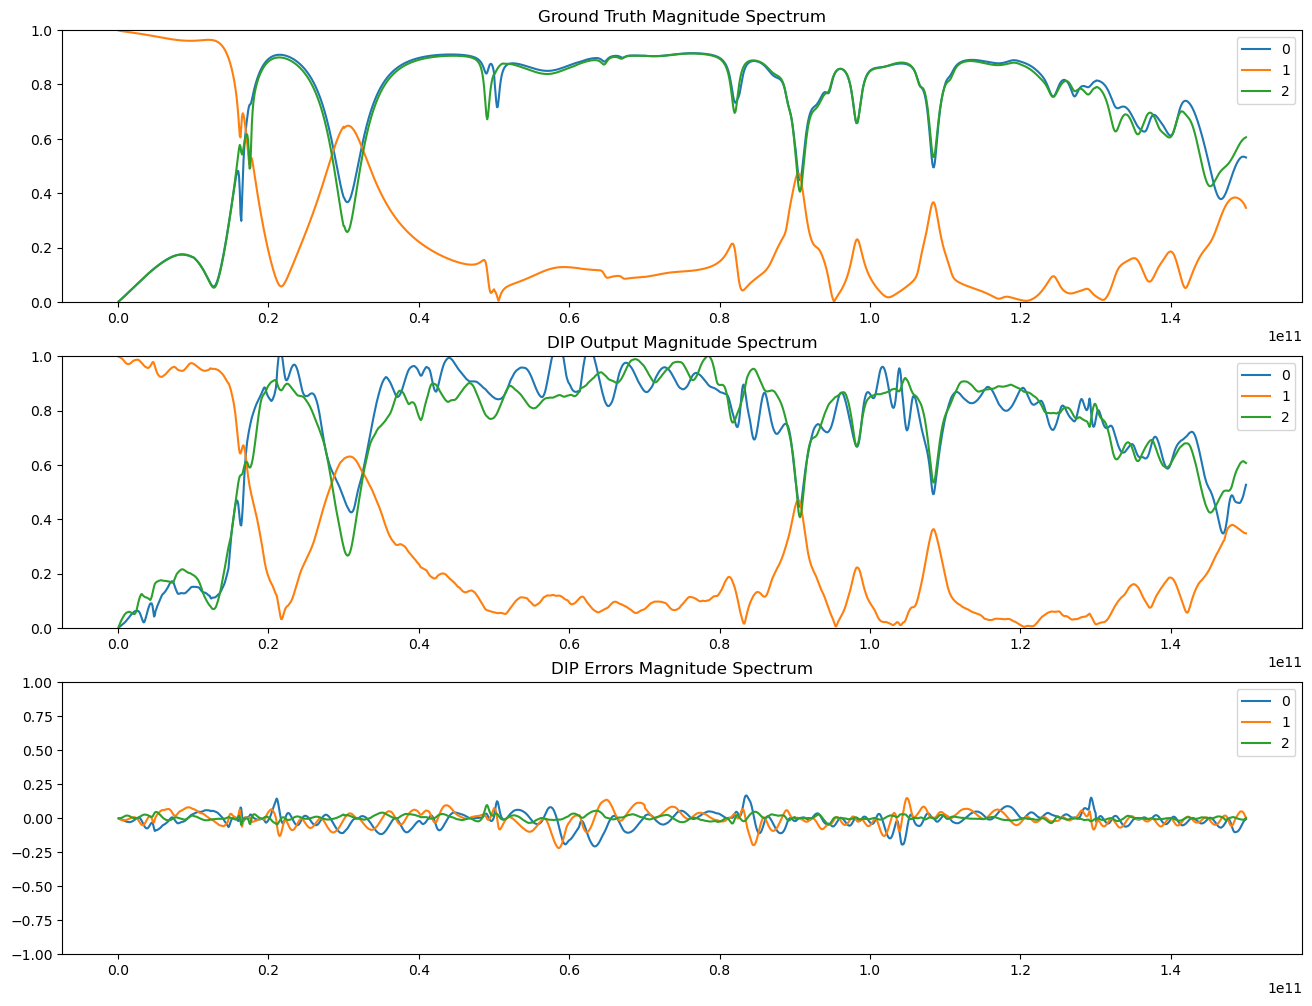

In [53]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

In [54]:
print(kept_inds)

[   0   24   45   73  122  146  151  160  165  172  192  207  221  244
  270  315  319  368  417  466  516  565  614  663  712  761  810  826
  860  895  903  904  905  909  922  958  979  988 1007 1035 1056 1080
 1084 1085 1105 1154 1204 1227 1253 1268 1273 1290 1302 1321 1351 1360
 1374 1400 1426 1449 1475 1499]
